Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               200960    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 233,985
Trainable params: 233,985
Non-t

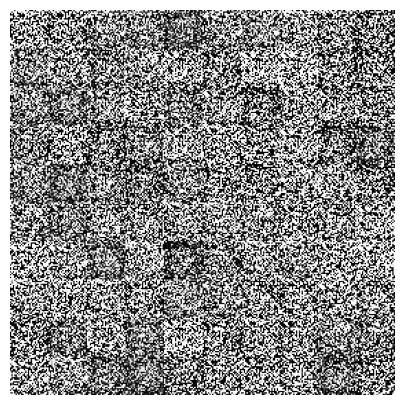

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import BatchNormalization, Input, Dense, Reshape, Flatten, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

def build_generator(latent_dim: int):

  """
  Build discriminator network
  :param latent_dim: latent vector size
  """
  model = Sequential([Dense(1024, input_dim=latent_dim),LeakyReLU(alpha=0.2),BatchNormalization(momentum=0.8),
                      Dense(2048),LeakyReLU(alpha=0.2),BatchNormalization(momentum=0.8),
                      Dense(4096),LeakyReLU(alpha=0.2),BatchNormalization(momentum=0.8),
                      Dense(np.prod((28, 28,1)), activation='tanh'),Reshape((28, 28,1))])
  model.summary()
 
  z = Input(shape=(latent_dim,))
  generated= model(z)

# build model from the input and output
  return Model(z, generated)

def build_discriminator():
  """
  Build discriminator network
  """
  model = Sequential([
                      Flatten(input_shape=(28, 28, 1)),
                      Dense(256),
                      LeakyReLU(alpha=0.2),
                      Dense(128),
                      LeakyReLU(alpha=0.2),
                      Dense(1, activation='sigmoid'),
                      ], name='discriminator')
  model.summary()
  image = Input(shape=(28, 28, 1))
  output = model(image)
  return Model(image, output)



def train(generator, discriminator, combined, steps, batch_size):
  """
  Train the GAN system
  :param generator: generator
  :param discriminator: discriminator
  :param combined: stacked generator and discriminator
  we'll use the combined network when we train the generator
  :param steps: number of alternating steps for training
  :param batch_size: size of the minibatch
  """
  # Load the dataset
  (x_train, _), _ = mnist.load_data()
  # Rescale in [-1, 1] interval
  x_train = (x_train.astype(np.float32) - 127.5) / 127.5
  x_train = np.expand_dims(x_train, axis=-1)
  # Discriminator ground truths
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))
  latent_dim = generator.input_shape[1]


  for step in range(steps):
    # Train the discriminator
    # Select a random batch of images
    real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
    # Random batch of noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # Generate a batch of new images
    generated_images = generator.predict(noise)
    # Train the discriminator
    discriminator_real_loss = discriminator.train_on_batch(real_images, real)
    discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake)
    discriminator_loss = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
    # Train the generator
    # random latent vector z
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # Train the generator
    # Note that we use the "valid" labels for the generated images
    # That's because we try to maximize the discriminator loss
    generator_loss = combined.train_on_batch(noise, real)
    # Display progress
    print("%d [Discriminator loss: %.4f%%, acc.: %.2f%%] [Generator loss: %.4f%%]" %
    (step, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))

def plot_generated_images(generator):
  """
  Display a nxn 2D manifold of digits
  :param generator: the generator
  """
  n = 10
  digit_size = 28
  # big array containing all images
  figure = np.zeros((digit_size * n, digit_size * n))
  latent_dim = generator.input_shape[1]
  # n*n random latent distributions
  noise = np.random.normal(0, 1, (n * n, latent_dim))
  # generate the images
  generated_images = generator.predict(noise)
  # fill the big array with images
  for i in range(n):
    for j in range(n):
      slice_i = slice(i * digit_size, (i + 1) * digit_size)
      slice_j = slice(j * digit_size, (j + 1) * digit_size)
      figure[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28, 28))
  # plot the results
  plt.figure(figsize=(6, 5))
  plt.axis('off')
  plt.imshow(figure, cmap='Greys_r')

if __name__ == '__main__':
  latent_dim = 64
  # Build and compile the discriminator
  discriminator = build_discriminator()
  discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5),

  metrics=['accuracy'])

  # Build the generator
  generator = build_generator(latent_dim)
  # Generator input z
  z = Input(shape=(latent_dim,))
  generated_image = generator(z)
  # Only train the generator for the combined model
  discriminator.trainable = False
  # The discriminator takes generated image as input and determines validity
  real_or_fake = discriminator(generated_image)
  # Stack the generator and discriminator in a combined model
  # Trains the generator to deceive the discriminator
  combined = Model(z, real_or_fake)
  combined.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  # train the GAN system
  train(generator=generator,
        discriminator=discriminator,
        combined=combined,
        steps=100,
        batch_size=100)
  # display some random generated images
  plot_generated_images(generator)